# Investigating PNM using 'Toy GP' analysis

## Alexandra Semposki

### Date: 10 September 2024

Let's investigate how we can fit a GP to the PNM results that we get from the BUQEYE truncation error model. We'll see if we can replicate the behaviour of the SNM results that we were seeing yesterday.

In [67]:
%load_ext autoreload
%autoreload 2

# import packages
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from matplotlib.axes import Axes

sys.path.append('../src')
sys.path.append('../data')

from gp_utils import GaussianProcessRegressor2dNoise
from eos_utils import *
from scripts import *

setup_rc_params()

# define saturation up here
n0 = 0.164

# color plotting assistance
orders = [0, 1, 2, 3]
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues','Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
data_xeft = np.load('../data/eos_data/PNM_chiral_scaled_2n0.npz')
print(data_xeft['density'].shape)
data_pqcd = np.load('../data/eos_data/pressure_pqcd_data_scaled.npz')  # unnecessary but need more general code

# get the training points we'd like to begin with
cutoff = 40
training_chiral, _, _ = gp_data(data_xeft, data_pqcd, cutoff, matter='PNM')

# cut the pQCD data out for now
training_data_2 = {
    'dens': training_chiral['dens'],
    'mean': training_chiral['mean'],
    'std': training_chiral['std'],
    'cov': training_chiral['cov']
}
# label pQCD data for later
# training_pqcd = {
#     'dens': training_data_full['dens'][7:],
#     'mean': training_data_full['mean'][7:],
#     'std': training_data_full['std'][7:],
#     'cov': training_data_full['cov'][7:,7:],
# }

# assign testing array (no equal points in training)
density_test = np.linspace(0.05, 16.4, 900)[:-1]

# cut this in half to obtain starting data
training_data = {
    'dens': training_data_2['dens'][::2],
    'mean': training_data_2['mean'][::2],
    'std': training_data_2['std'][::2],
    'cov': training_data_2['cov'][::2,::2]
}

# print results to check
print('Density: \n', training_data_2['dens'])
print('\nMean: \n', training_data_2['mean'])
print('\nStd dev: \n', training_data_2['std'])

print('\nDensity: \n', training_data['dens'])
print('\nMean: \n', training_data['mean'])
print('\nStd dev: \n', training_data['std'])

(300,)
(14,) (14,) (14,) (14, 14)
(14,) (14,) (14,) (14, 14)
(4,) (4,) (4,) (4, 4)
Cov shape: (18, 18)
Density: 
 [0.10916388 0.12662207 0.14408027 0.16153846 0.17899666 0.19645485
 0.21391304 0.23137124 0.24882943 0.26628763 0.28374582 0.30120401
 0.31866221 0.3361204 ]

Mean: 
 [0.02042698 0.02510502 0.03069609 0.03701746 0.04385838 0.05099691
 0.05821146 0.0652886  0.07202813 0.07824645 0.08377842 0.08847835
 0.09222021 0.09489743]

Std dev: 
 [0.00216668 0.00298757 0.0039638  0.00510529 0.00642277 0.00792788
 0.00963331 0.01155284 0.01370153 0.016096   0.01875471 0.02169835
 0.02495021 0.02853659]

Density: 
 [0.10916388 0.14408027 0.17899666 0.21391304 0.24882943 0.28374582
 0.31866221]

Mean: 
 [0.02042698 0.03069609 0.04385838 0.05821146 0.07202813 0.08377842
 0.09222021]

Std dev: 
 [0.00216668 0.0039638  0.00642277 0.00963331 0.01370153 0.01875471
 0.02495021]


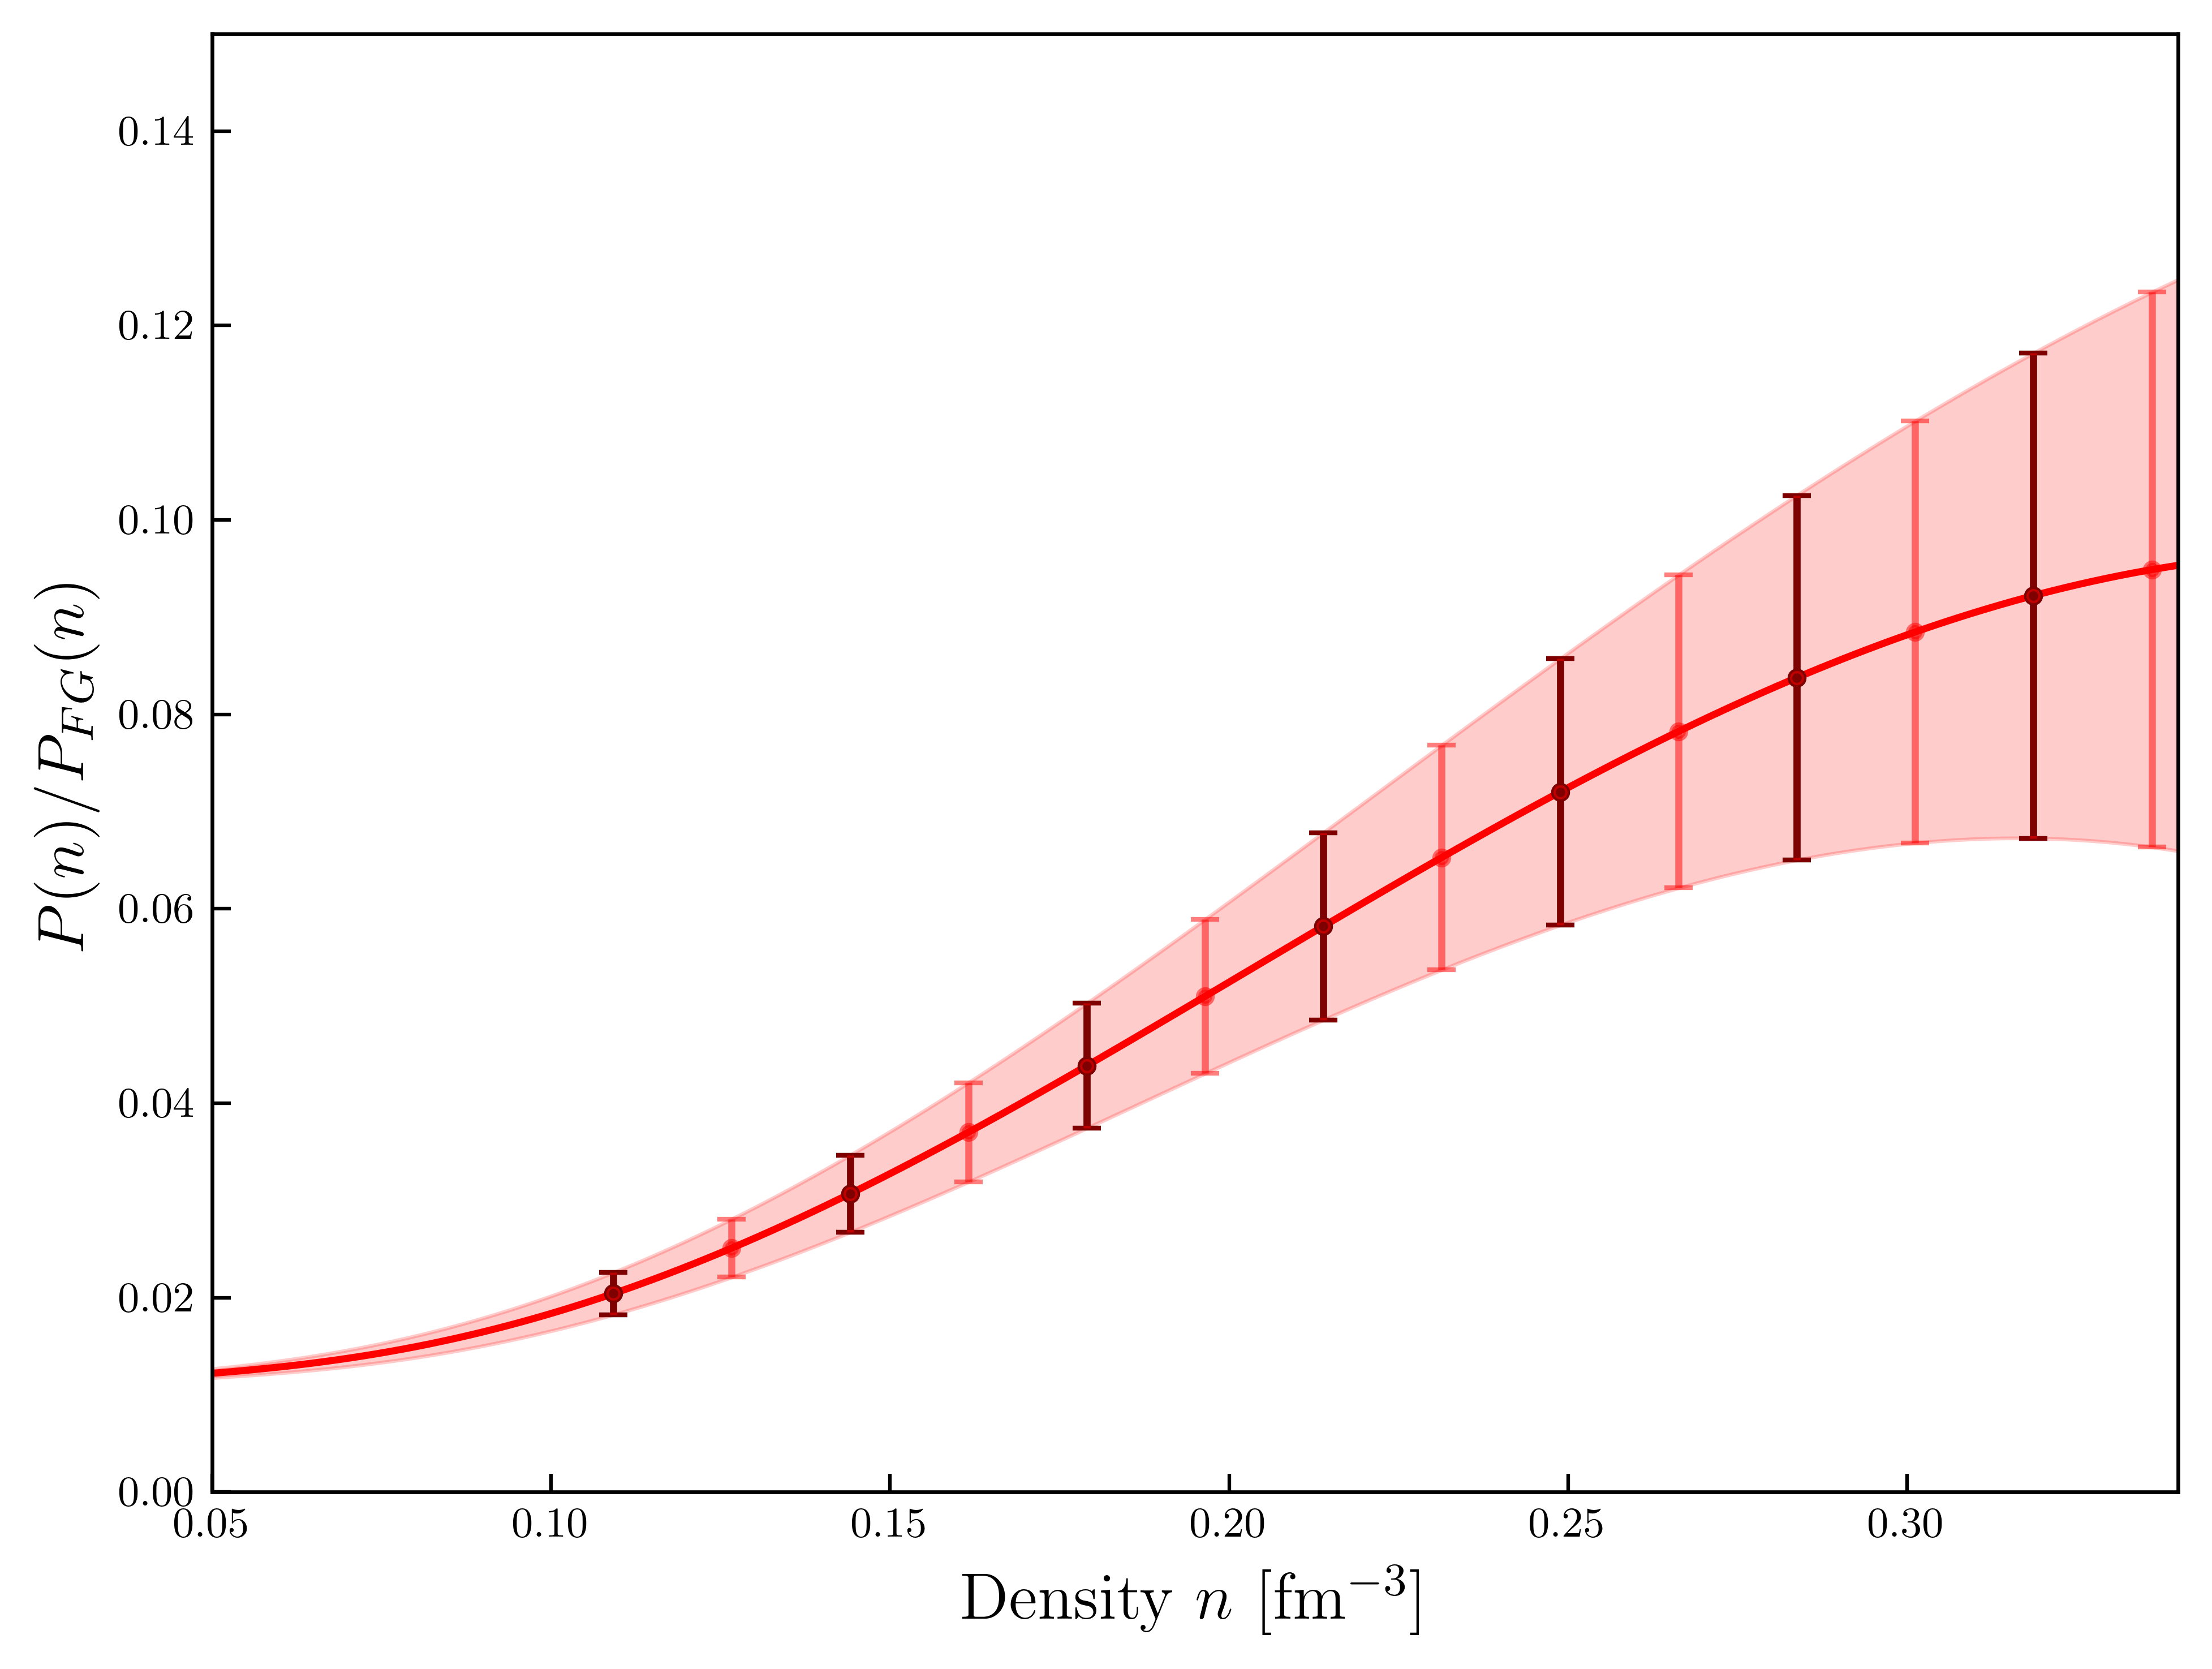

In [76]:
errorbar_kwargs = dict(
    capsize=3,
    ecolor="k",
    ls="none",
    marker="o",
    markerfacecolor="k",
    markeredgecolor="k",
    markersize=3
)

errorbar_kwargs_2 = dict(
    capsize=3,
    ecolor="r",
    ls="none",
    marker="o",
    markerfacecolor="r",
    markeredgecolor="r",
    markersize=3,
    alpha=0.5
)

# chiral EFT data 
n_xeft = data_xeft['density']
p_mean_xeft = data_xeft['mean'][:, -1]
p_stdv_xeft = data_xeft['std_dev'][:, -1]
p_cov_xeft = data_xeft['cov'][..., -1]

# plot the current data sets
fig, ax = plt.subplots(dpi=600)
ax: Axes
color_xeft = "red"
color_pqcd = "blue"
# ax.set_xlim(1.0, 100.0)
# ax.set_ylim(0, 1.2)
ax.set_xlim(0.05, 0.34)
ax.set_ylim(0.0, 0.15)
#ax.set_xscale('log')
ax.set_ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)
ax.set_xlabel(r'Density $n$ [fm$^{-3}$]', fontsize=14)
ax.plot(n_xeft, p_mean_xeft, color='red', label=r'ChEFT (N3LO)')
ax.fill_between(n_xeft, p_mean_xeft-p_stdv_xeft, \
                p_mean_xeft+p_stdv_xeft, alpha=0.2, color=color_xeft)
ax.errorbar(x=training_data['dens'], y=training_data['mean'], yerr=training_data['std'], **errorbar_kwargs)
ax.errorbar(x=training_data_2['dens'], y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2)
plt.show()

In [77]:
# print(training_data['cov'])
# print('\n')
# print(training_data_2['cov'])

print('Eigenvalues of the small covariance matrix: \n{}'.format(np.linalg.eig(training_data['cov'])[0]))

Eigenvalues of the small covariance matrix: 
[1.28727983e-03 2.83416293e-05 7.93059864e-07 2.77903272e-08
 8.54706277e-10 3.46930999e-11 2.39721550e-13]


In [82]:
# set up the kernel
if cutoff == 20:
    kernel = C(constant_value=1.1, constant_value_bounds=[0.3,2.25]) * \
    RBF(length_scale=0.8, length_scale_bounds=[0.3,1.0])  # 40n0 => 0.9, [0.7,1.2] # 20n0 => 1.1?
elif cutoff == 40:
    kernel = C(constant_value=1.1, constant_value_bounds=[0.3,2.25]) * \
    RBF(length_scale=0.9, length_scale_bounds=[0.6,1.2])  # 40n0 => 0.9, [0.7,1.2] # 20n0 => 1.1?
#kernel = C(constant_value=0.6) * RBF(length_scale=1.16, length_scale_bounds='fixed')

X_train = np.log(training_data['dens']).reshape(-1,1)  # training in the log scale
X_train_2 = np.log(training_data_2['dens']).reshape(-1,1)
y_train = training_data['mean'].reshape(-1,1)
y_train_2 = training_data_2['mean'].reshape(-1,1)

# chicken nugget
nugget = 1e-08*np.eye(len(training_data['cov']))
nugget2 = 1e-08*np.eye(len(training_data_2['cov']))

# set up the class for the GP
gp = GaussianProcessRegressor2dNoise(
    kernel=kernel,
    alpha=training_data['cov'] + nugget,  # here is where we input the full covariance matrix from the data
    n_restarts_optimizer=10000)

gp1 = GaussianProcessRegressor2dNoise(
    kernel=kernel,
    alpha=training_data_2['cov'] + nugget2,  # here is where we input the full covariance matrix from the data
    n_restarts_optimizer=10000)

gp.fit(X_train, y_train, cutoff=cutoff, priors=True, prior_choice='truncnorm_15')  
gp1.fit(X_train_2, y_train_2, cutoff=cutoff, priors=True, prior_choice='truncnorm_15')  

print(gp.kernel_)
print(gp1.kernel_)

0.903**2 * RBF(length_scale=1.14)
0.895**2 * RBF(length_scale=1.15)


In [83]:
# predict using this GP
X = np.log(density_test).reshape(-1,1)
y_pred, y_stdv = gp.predict(X, return_std=True)
_ , y_cov = gp.predict(X, return_cov=True)

y_pred_2, y_stdv_2 = gp1.predict(X, return_std=True)
_ , y_cov_2 = gp1.predict(X, return_cov=True)

In [84]:
# compare the size of the error bars for both theories below at some select point (last point)
band_chiral = p_stdv_xeft[-1]
band_gp = y_stdv[16]           # 2n0
band_gp1 = y_stdv_2[16]

print('Density at chosen point:', density_test[16], 'fm^-3')

# differences to highlight on the plot for compact saving
diff_chiral_gp1 = round(((band_chiral - band_gp)/(band_chiral))*100, 2)
diff_chiral_gp2 = round(((band_chiral - band_gp1)/(band_chiral))*100, 2)
diff_gps = round(((band_gp - band_gp1)/(band_gp + band_gp1))*100, 2)

# print out the differences
print('Difference between chiral and GP with 4 points: ', diff_chiral_gp1)
print('Difference between chiral and GP with 2x points: ', diff_chiral_gp2)
print('Difference between the two GPs: ', diff_gps)

Density at chosen point: 0.3409899888765294 fm^-3
Difference between chiral and GP with 4 points:  5.65
Difference between chiral and GP with 2x points:  6.89
Difference between the two GPs:  0.66


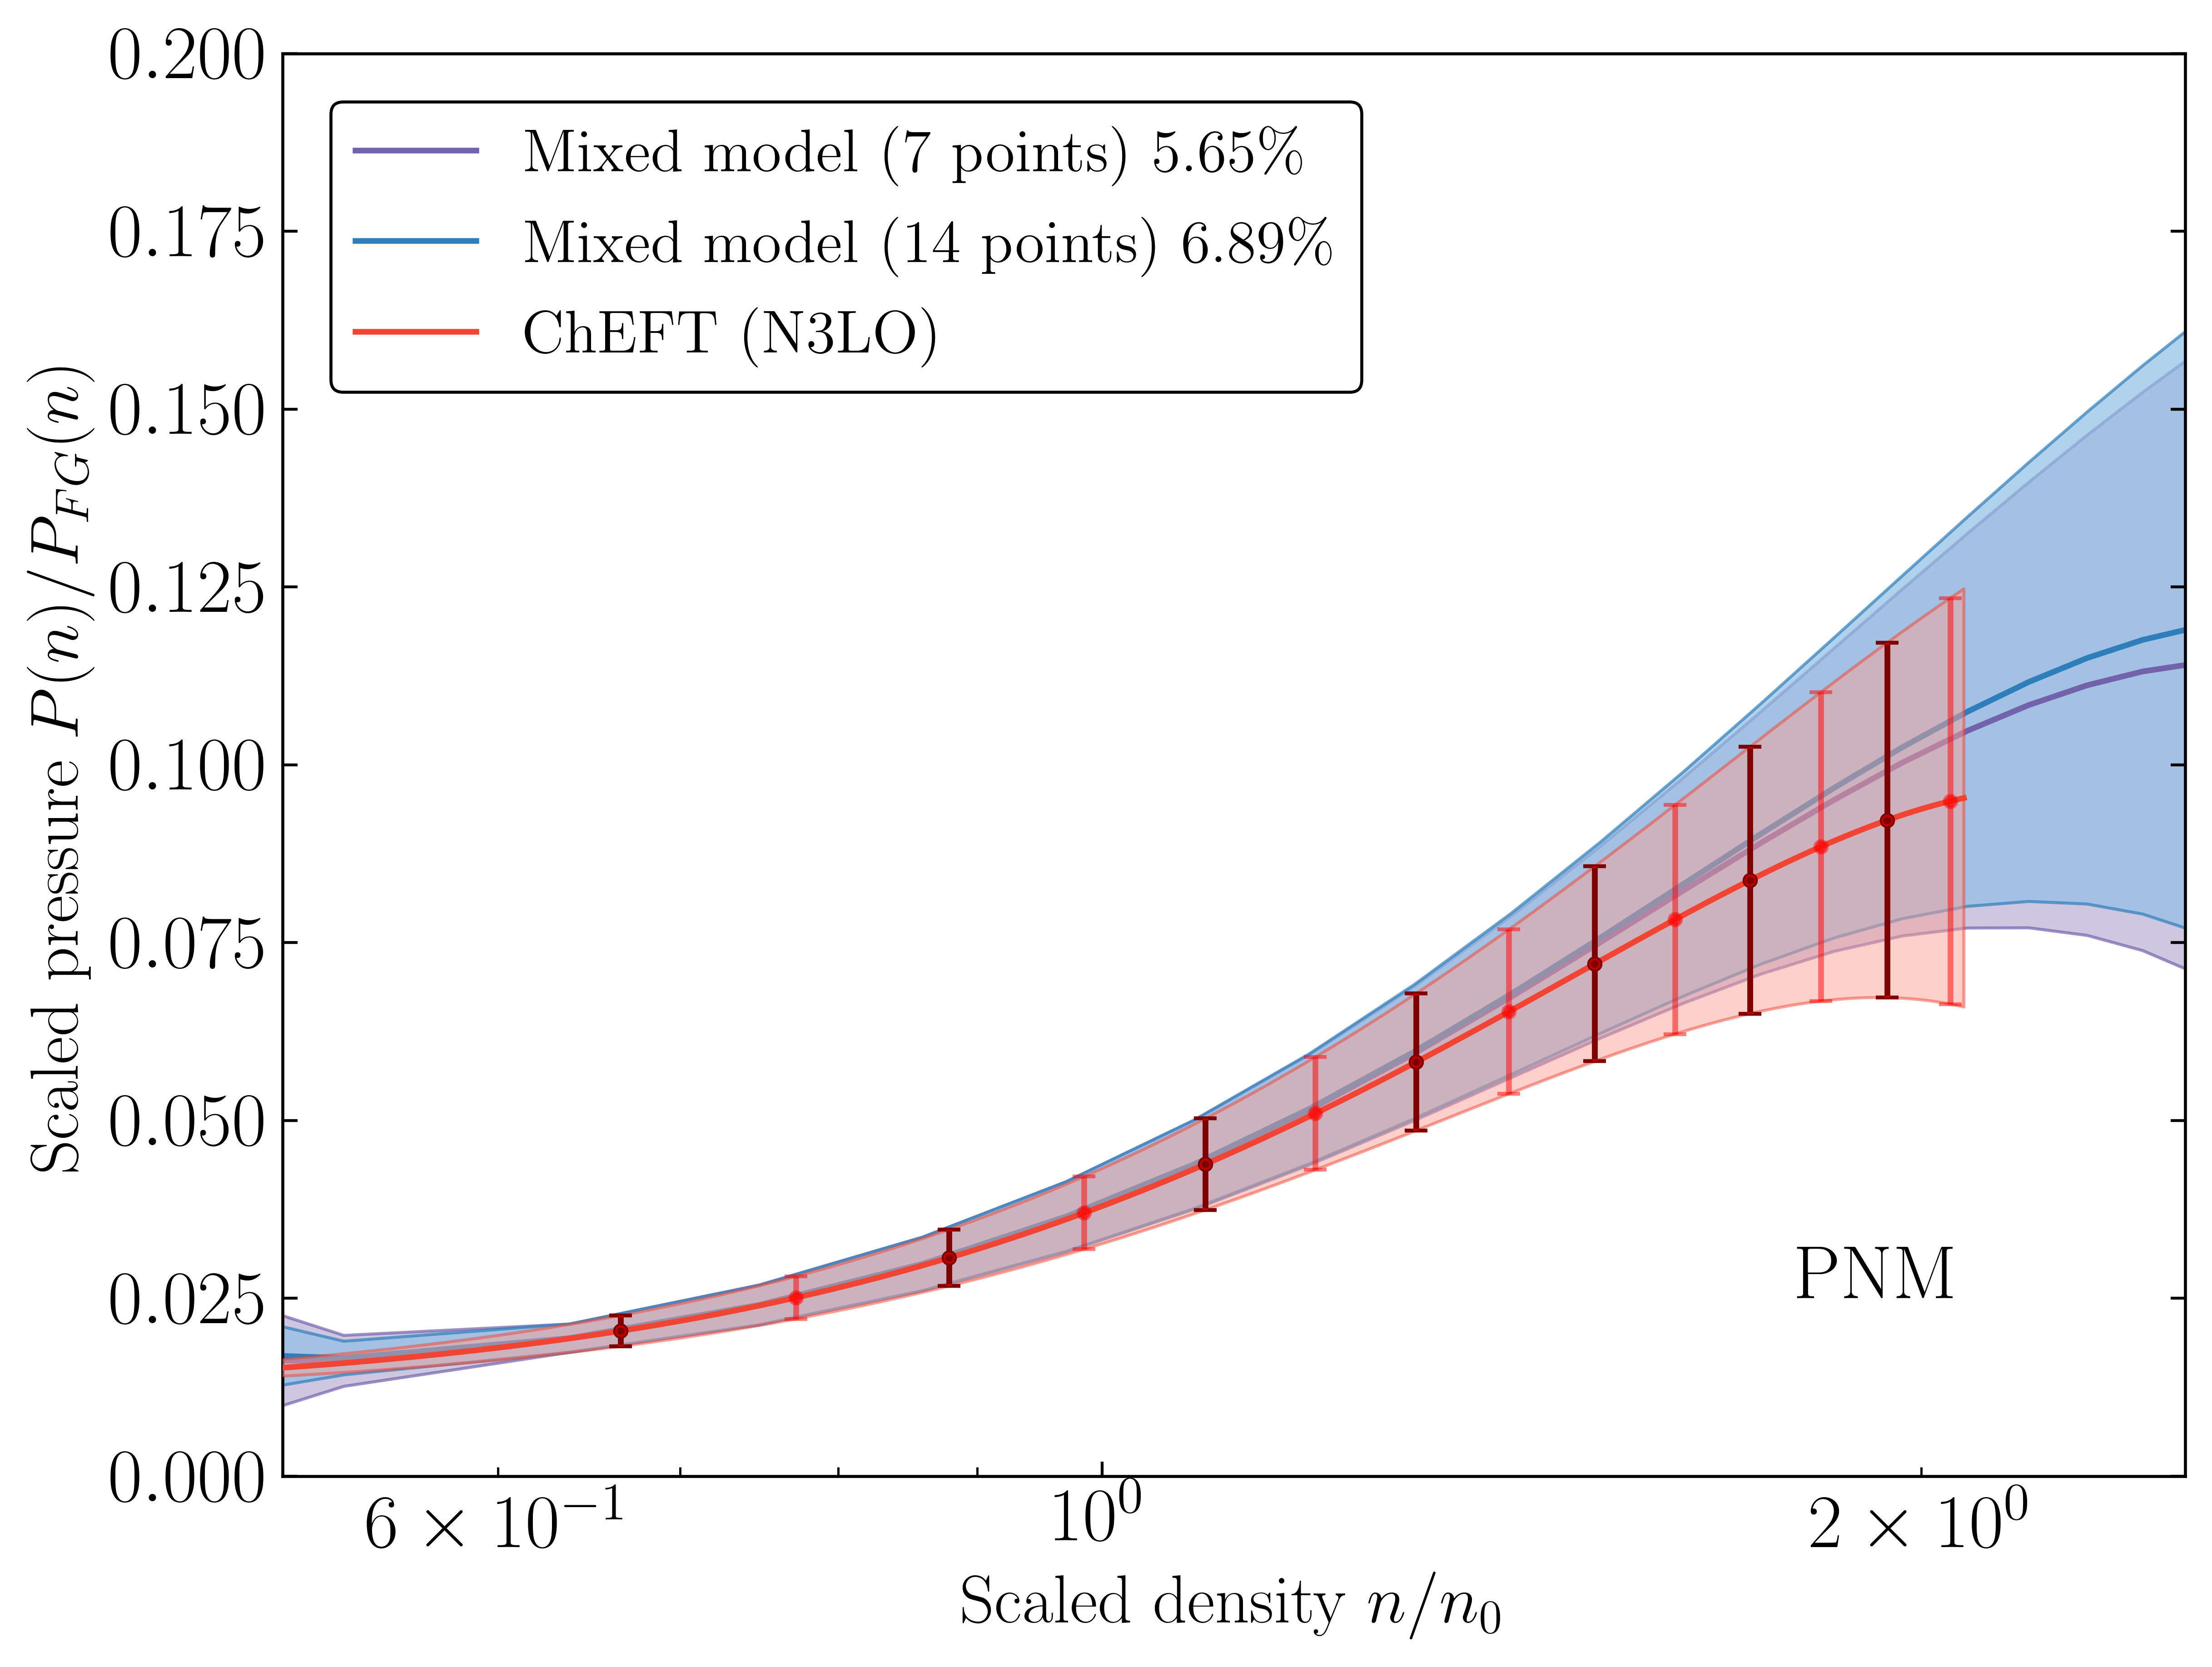

In [85]:
fig, ax = plt.subplots(figsize=(8,6), dpi=600)
ax.set_xlim(0.5, 2.5)
#ax.set_ylim(-0.1, 1.4)
ax.tick_params(axis='both', which='major', labelsize=20, right=True)
ax.tick_params(axis='both', which='minor', labelsize=20, right=True)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_xscale('log') # plot in log base 10
ax.set_xlabel(r'Scaled density $n/n_{0}$', fontsize=18)

# GP results and uncertainty bands
ax.plot(density_test/n0, y_pred, c=colors[2], \
        label=r'Mixed model ({} points) {}\%'.format(len(training_data['cov']), diff_chiral_gp1), zorder=-1)
ax.fill_between(density_test/n0, y_pred-y_stdv, y_pred+y_stdv, facecolor=light_colors[2], \
                edgecolor=colors[2], alpha=0.7, zorder=-2)

ax.plot(density_test/n0, y_pred_2, c=colors[1], \
        label=r'Mixed model ({} points) {}\%'.format(len(training_data_2['cov']), diff_chiral_gp2), zorder=-1)
ax.fill_between(density_test/n0, y_pred_2-y_stdv_2, y_pred_2+y_stdv_2, facecolor=light_colors[1], \
                edgecolor=colors[1], alpha=0.7, zorder=-2)

# chiral EFT and pQCD curves, training data
ax.plot(n_xeft/n0, p_mean_xeft, color=colors[0], label=r'ChEFT (N3LO)', zorder=5)
ax.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, alpha=0.5, \
                facecolor=light_colors[0], edgecolor=colors[0], zorder=4)
ax.errorbar(x=training_data['dens']/n0, y=training_data['mean'], yerr=training_data['std'], \
            **errorbar_kwargs, zorder=10)
ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2, zorder=10)

ax.set_ylim(0, 0.2)
ax.set_ylabel(r'Scaled pressure $P(n)/P_{FG}(n)$', fontsize=18)
ax.text(1.8, 0.025, r'PNM', fontsize=20)
plt.legend(loc='upper left', fontsize=16)
plt.show()

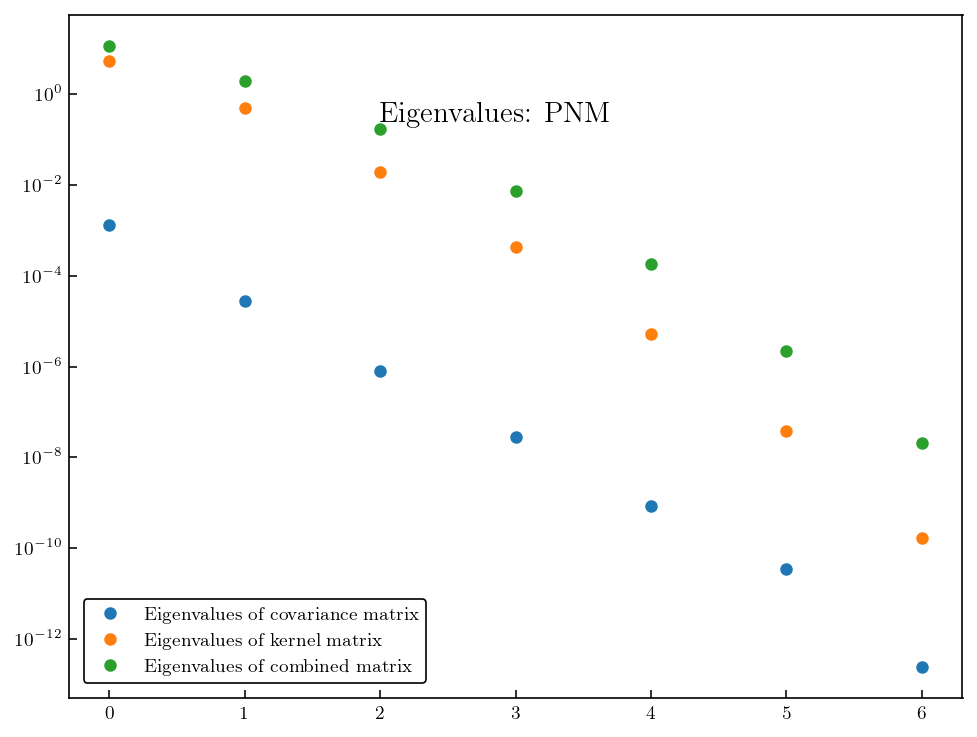

In [66]:
# get the SVD up and running
from scipy.linalg import svd
U_cov, S_cov, V_cov = svd(training_data['cov'])

# get SVD from the kernel matrix (get the kernel matrix...how?)
# set the kernel with optimized parameters from the training and then use that at the training points?
kernel = C(0.912**2.0, constant_value_bounds='fixed') \
* RBF(length_scale=1.12, length_scale_bounds='fixed')

# construct a new GP to tackle this?
gp_cov = GaussianProcessRegressor2dNoise(kernel, alpha=training_data['cov'])
gp_cov.fit(X_train, y_train)

# covariance matrix from kernel and SVD
cov_kernel = gp_cov.K_copy
U_kernel, S_kernel, V_kernel = svd(cov_kernel)

# combined covariance matrix (K(X,X)+alpha)
cov_combined = gp.K_copy + training_data['cov']
U_combined, S_combined, V_combined = svd(cov_combined)

# compare using svd
plt.plot(S_cov, '.', markersize=10, label=r'Eigenvalues of covariance matrix')
plt.plot(S_kernel, '.', markersize=10, label=r'Eigenvalues of kernel matrix')
plt.plot(S_combined, '.', markersize=10, label=r'Eigenvalues of combined matrix')
plt.yscale('log')
plt.text(2.0, 2.5e-1, r'Eigenvalues: PNM', fontsize=14)
plt.legend(loc='lower left')
plt.show()